In [20]:
import matplotlib.pyplot as plt
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import nibabel as nib
from scipy import ndimage
import glob
import sys,os
from natsort import natsorted
import tensorflow_probability as tfp
import random
from aifnet_utils.preprocess import read_nifti_file, normalize, normalize_aif, process_scan, normalize_zero_one
from aifnet_utils.losses import MaxCorrelation
from aifnet_utils.data_loaders import read_isles_annotations_from_file, read_isles_volumes_from_file, ISLES18DataGen_aifvof_aug
from aifnet_utils.data_loaders import delay_sequence_padding, anticipate_sequence_padding, late_bolus, early_bolus
from aifnet_utils.results import plot_predictions
%matplotlib inline

!pwd

/home/sebastian/experiments/aifnet_replication


In [3]:
keras.backend.set_image_data_format('channels_last')

In [4]:
root_dir     = '/media/sebastian/data/ASAP/ISLES2018_Training/'
#At insel: /media/sebastian/data/ASAP/ISLES2018_Training
#Local: '/Users/sebastianotalora/work/postdoc/data/ISLES/'
aif_annotations_path = '/home/sebastian/experiments/aifnet_replication/annotated_aif_vof_complete_revised.csv'
min_num_volumes_ctp = 43
ROOT_EXP = '/home/sebastian/experiments/aifnet_replication'#'/Users/sebastianotalora/work/postdoc/ctp/aifnet_replication'


In [5]:
current_fold = 1
#Reading AIFs and VOFs for each of the partitions
train_partition_path = '/home/sebastian/experiments/aifnet_replication/partitions/fold_'+str(current_fold) +'/train.txt'
valid_partition_path = '/home/sebastian/experiments/aifnet_replication/partitions/fold_'+str(current_fold) +'/valid.txt'
test_partition_path = '/home/sebastian/experiments/aifnet_replication/partitions/fold_'+str(current_fold) +'/test.txt'

aif_annotations_train, vof_annotations_train = read_isles_annotations_from_file(aif_annotations_path, train_partition_path, 
                                                root_dir, min_num_volumes_ctp, return_aif_only = False)
aif_annotations_valid, vof_annotations_valid = read_isles_annotations_from_file(aif_annotations_path, valid_partition_path, root_dir, 
                                         min_num_volumes_ctp, return_aif_only = False)
aif_annotations_test, vof_annotations_test = read_isles_annotations_from_file(aif_annotations_path,  test_partition_path,
                                        root_dir, min_num_volumes_ctp, return_aif_only = False)

In [6]:
ctp_volumes_train = read_isles_volumes_from_file(root_dir, train_partition_path, aif_annotations_path,
                                                 min_num_volumes_ctp, take_two_slices_only=False)
ctp_volumes_valid = read_isles_volumes_from_file(root_dir, valid_partition_path, aif_annotations_path,
                                                 min_num_volumes_ctp, take_two_slices_only=False)
ctp_volumes_test = read_isles_volumes_from_file(root_dir, test_partition_path, aif_annotations_path,
                                                 min_num_volumes_ctp, take_two_slices_only=False)

In [7]:
print(len(ctp_volumes_train), len(aif_annotations_train))
print(len(ctp_volumes_valid), len(aif_annotations_valid))
print(len(ctp_volumes_test), len(aif_annotations_test))

64 64
9 9
21 21


In [8]:
64+9+21

94

In [9]:
def get_model_twoPvols(width=256, height=256, num_channels=43):
    """Build a 3D convolutional neural network model."""
    #width and height of the PCT is 256, the number of slices is variable, and the number of channels are
    #the number of timepoints in the PCT sequence        
    inputs = keras.Input((width, height, None , 43))

    x = layers.Conv3D(filters=16, kernel_size=(3,3,1), activation="relu", data_format='channels_last', padding='same')(inputs)
    #x = layers.Dropout(0.3)(x)
    
    x = layers.Conv3D(filters=32, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    #x = layers.Dropout(0.3)(x)
    
    x = layers.Conv3D(filters=64, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    #x = layers.Dropout(0.3)(x)
    
    x = layers.Conv3D(filters=128, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)

    #x = layers.Conv3D(filters=256, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    #x = layers.Dropout(0.3)(x)
    Lout = layers.Conv3D(filters=1, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)
    Lout2 = layers.Conv3D(filters=1, kernel_size=(3,3,3), activation="relu", data_format='channels_last', padding='same')(x)

    P_vol_aif = tf.keras.activations.sigmoid(Lout,name="aif")
    P_vol_vof = tf.keras.activations.sigmoid(Lout2,name="vof")
    #Voxelwise multiplication of P_vol and each of the CTP time points    
    voxelwise_mult_each_ctp_aif = tf.keras.layers.Multiply()([inputs,P_vol_aif])    
    voxelwise_mult_each_ctp_vof = tf.keras.layers.Multiply()([inputs,P_vol_vof])        
    #The 3D average pooling block averages the volumetric information along the x-y-z axes, 
    #such that the predicted vascular function y(t) is a 1D vector of length T.
    outputs_aif = layers.GlobalAveragePooling3D(data_format='channels_last', name='aif_loss')(voxelwise_mult_each_ctp_aif)
    outputs_vof = layers.GlobalAveragePooling3D(data_format='channels_last', name='vof_loss')(voxelwise_mult_each_ctp_vof)    
    #outputs_aif = tf.keras.activations.linear

    # Define the model.
    model = keras.Model(inputs, [outputs_aif,outputs_vof], name="aifnet")
    return model

Model: "aifnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, No 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 256, 256, Non 6208        input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 256, 256, Non 13856       conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 256, 256, Non 55360       conv3d_1[0][0]                   
_____________________________________________________________________________________________

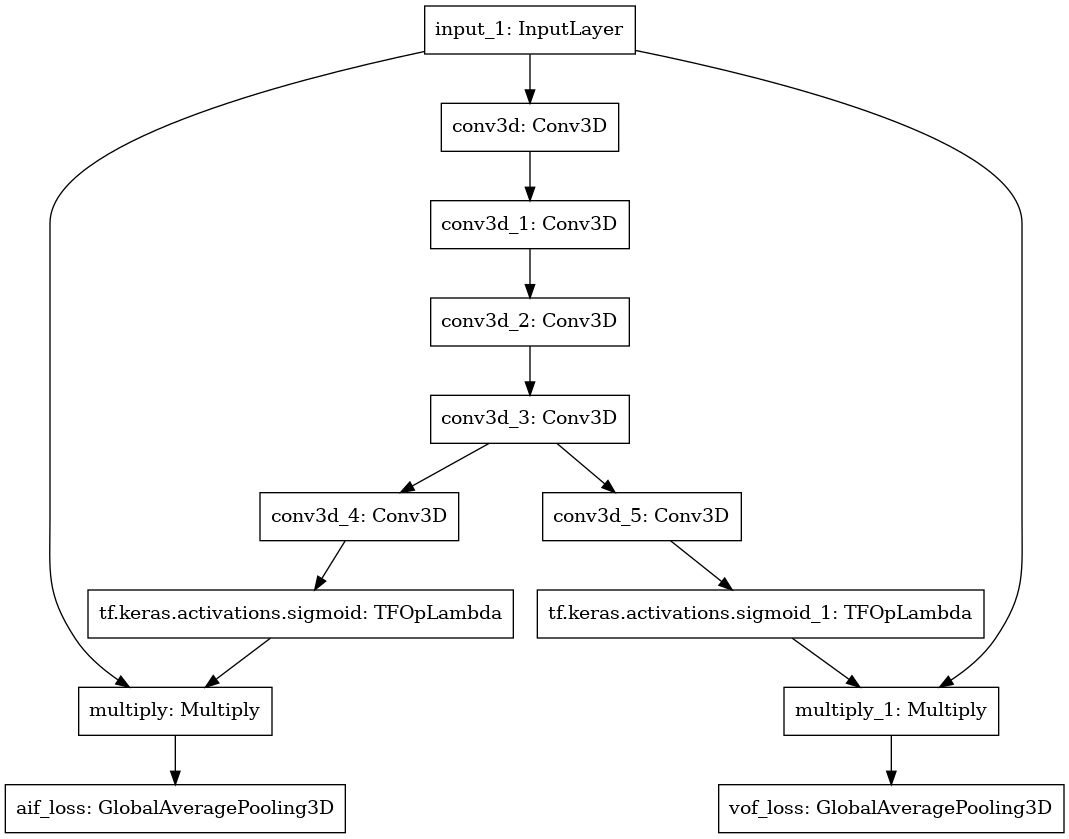

In [10]:
# Build model.
model = get_model_twoPvols(width=256, height=256, num_channels=43)
model.summary()
tf.keras.utils.plot_model(
    model,
    to_file="aifnet.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [11]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.96, staircase=True
)

In [12]:
optimizer_aifnet = optimizer = keras.optimizers.SGD(learning_rate=lr_schedule) #keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(
    loss=[MaxCorrelation,MaxCorrelation],
    optimizer=optimizer_aifnet,
    metrics=['mae'])

In [13]:
# Define callbacks.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_aif_loss_mae", patience=3)
path_checkpointer_model = ROOT_EXP +'/results/' 
path_checkpointer_model += 'aifnet_2Pvols_augment_lr' + str(initial_learning_rate) + '_fold_' + str(current_fold) +'.hdf5'
path_tensorboard_log    = ROOT_EXP + '/results/logsTensorBoard/'
path_tensorboard_log    += 'aifnet_2Pvols_augment_lr' + str(initial_learning_rate) + '_fold_' + str(current_fold) 

checkpointer = ModelCheckpoint(filepath=path_checkpointer_model, monitor='val_aif_loss_mae', 
                               verbose=1, save_best_only=True)
tb_callback = TensorBoard(log_dir=path_tensorboard_log, histogram_freq=0, write_graph=True, write_grads=False,
                          write_images=False, embeddings_freq=0, embeddings_layer_names=None,
                          embeddings_metadata=None)


In [14]:
train_datagen = ISLES18DataGen_aifvof_aug(ctp_volumes=ctp_volumes_train, annotations_aif=aif_annotations_train,
                               annotations_vof=vof_annotations_train,minimum_number_volumes_ctp = 43, batch_size=1,
                                         time_arrival_augmentation = True)
validation_datagen =  ISLES18DataGen_aifvof_aug(ctp_volumes=ctp_volumes_valid, annotations_aif=aif_annotations_valid,
                               annotations_vof=vof_annotations_valid,minimum_number_volumes_ctp = 43, batch_size=1,
                                         time_arrival_augmentation = True)

In [15]:
nb_epochs=4
model.fit(train_datagen,batch_size=1,callbacks=[checkpointer,tb_callback,early_stopping_cb],
          epochs=nb_epochs, validation_data=validation_datagen)

/home/sebastian/anaconda3/envs/aifnet/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/4
64/64 [==============================] - 71s 1s/step - loss: -1.6104 - aif_loss_loss: -0.8055 - vof_loss_loss: -0.8049 - aif_loss_mae: 0.3543 - vof_loss_mae: 0.3527 - val_loss: -1.6318 - val_aif_loss_loss: -0.8175 - val_vof_loss_loss: -0.8144 - val_aif_loss_mae: 0.3787 - val_vof_loss_mae: 0.3768

Epoch 00001: val_aif_loss_mae improved from inf to 0.37866, saving model to /home/sebastian/experiments/aifnet_replication/results/aifnet_2Pvols_augment_lr0.001_fold_1.hdf5
Epoch 2/4
64/64 [==============================] - 34s 540ms/step - loss: -1.6091 - aif_loss_loss: -0.8049 - vof_loss_loss: -0.8042 - aif_loss_mae: 0.3537 - vof_loss_mae: 0.3522 - val_loss: -1.6714 - val_aif_loss_loss: -0.8360 - val_vof_loss_loss: -0.8353 - val_aif_loss_mae: 0.3421 - val_vof_loss_mae: 0.3405

Epoch 00002: val_aif_loss_mae improved from 0.37866 to 0.34207, saving model to /home/sebastian/experiments/aifnet_replication/results/aifnet_2Pvols_augment_lr0.001_fold_1.hdf5
Epoch 3/4
64/64 [==============

In [72]:
import numpy as np
def plot_predictions(model,x,y,prefix_fig, normalize_preds=True, type_pred='AIF', savefig=True):
    pred = model.predict(np.expand_dims(normalize(x), axis=0))    
    if type_pred=='AIF':
        pred = pred[0][0]
        plt.title('AIF Function Predictions')        
    else:
        pred = pred[1][0]
        plt.title('VOF Function Predictions')

    if normalize_preds:
        #print('Normalizing')
        pred = normalize_zero_one(pred)
        y = normalize_zero_one(y)
    plt.plot(y)
    plt.plot(pred)    
    plt.legend(['y', 'prediction'])
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Density (HU)')
    if savefig:
        plt.savefig(prefix_fig +str(case_number) + '.png')
        plt.figure().clear()
        plt.close()
        plt.cla()
        plt.clf()
        return y,pred
    plt.show()
    return

In [71]:
tfp.stats.correlation(y_pred,y_true, sample_axis=None, event_axis=None)

NameError: name 'y_pred' is not defined

In [75]:
type_predictions = 'AIF'
results_meassures = []
prefix_fig = '/home/sebastian/experiments/aifnet_replication/results/predictions_aif/'+path_tensorboard_log.split('/')[-1]+'_'
for case_number in range(len(ctp_volumes_test)):
    case_id = ctp_volumes_test[case_number]['image'].split('.')[-2]
    x =  ctp_volumes_test[case_number]['ctpvals']
    if type_predictions == 'AIF':
        y = aif_annotations_test[case_id]
    if type_predictions == 'VOF':
        y = vof_annotations_test[case_id]
    results_meassures.append(plot_predictions(model,x,y, prefix_fig, True, type_predictions,True))


<Figure size 432x288 with 0 Axes>

In [76]:
results_meassures

[(array([0.09601971, 0.        , 0.09969336, 0.06033708, 0.1602994 ,
         0.15101941, 0.23050125, 0.22050815, 0.38713572, 0.55151444,
         0.64912307, 0.7779629 , 0.88893823, 0.92315329, 0.93129155,
         0.98498206, 0.89316954, 1.        , 0.75896258, 0.64192067,
         0.64687791, 0.46862187, 0.4314192 , 0.2159226 , 0.34338038,
         0.21488483, 0.2123785 , 0.4175338 , 0.24493687, 0.26847882,
         0.36723223, 0.34193261, 0.30349051, 0.37313306, 0.30462053,
         0.44617088, 0.31554538, 0.28896311, 0.37174539, 0.31573989,
         0.31100047, 0.21206836, 0.34418673]),
  array([0.        , 0.00373784, 0.00657138, 0.01446619, 0.00247604,
         0.02055855, 0.05291617, 0.1397758 , 0.23192915, 0.37223062,
         0.524237  , 0.64203656, 0.7767555 , 0.8439538 , 0.93090147,
         0.9782325 , 1.        , 0.97598976, 0.9421414 , 0.86590886,
         0.7867812 , 0.7033494 , 0.624227  , 0.5334904 , 0.45796934,
         0.4302618 , 0.40572324, 0.41550592, 0.38589466,

In [116]:
results_meassures

[(array([0.09601971, 0.        , 0.09969336, 0.06033708, 0.1602994 ,
         0.15101941, 0.23050125, 0.22050815, 0.38713572, 0.55151444,
         0.64912307, 0.7779629 , 0.88893823, 0.92315329, 0.93129155,
         0.98498206, 0.89316954, 1.        , 0.75896258, 0.64192067,
         0.64687791, 0.46862187, 0.4314192 , 0.2159226 , 0.34338038,
         0.21488483, 0.2123785 , 0.4175338 , 0.24493687, 0.26847882,
         0.36723223, 0.34193261, 0.30349051, 0.37313306, 0.30462053,
         0.44617088, 0.31554538, 0.28896311, 0.37174539, 0.31573989,
         0.31100047, 0.21206836, 0.34418673]),
  array([0.        , 0.00373784, 0.00657138, 0.01446619, 0.00247604,
         0.02055855, 0.05291617, 0.1397758 , 0.23192915, 0.37223062,
         0.524237  , 0.64203656, 0.7767555 , 0.8439538 , 0.93090147,
         0.9782325 , 1.        , 0.97598976, 0.9421414 , 0.86590886,
         0.7867812 , 0.7033494 , 0.624227  , 0.5334904 , 0.45796934,
         0.4302618 , 0.40572324, 0.41550592, 0.38589466,

In [125]:
prediction_ids = []
prediction_meassures = []

type_predictions = 'AIF'
results_meassures = []
prefix_fig = '/home/sebastian/experiments/aifnet_replication/results/predictions_aif/'+path_tensorboard_log.split('/')[-1]+'_'
for case_number in range(len(ctp_volumes_test)):
    case_id = ctp_volumes_test[case_number]['image'].split('.')[-2]
    prediction_ids.append(case_id)
    x =  ctp_volumes_test[case_number]['ctpvals']
    if type_predictions == 'AIF':
        y = aif_annotations_test[case_id]
    if type_predictions == 'VOF':
        y = vof_annotations_test[case_id]
    results_meassures.append(plot_predictions(model,x,y, prefix_fig, True, type_predictions,True))

preds_fold = tfp.stats.correlation(np.array(results_meassures)[:,1,:],np.array(results_meassures)[:,0,:], sample_axis=0, event_axis=None)
preds_fold = preds_fold.numpy()
prediction_meassures.append([preds_fold.mean(),preds_fold.std(),preds_fold.var()])

savetxt('results/pearson_fold_'+str(current_fold)+'.csv', prediction_meassures, delimiter=',',fmt='%1.5f')
savetxt('results/allpreds_fold_'+str(current_fold)+'.csv', np.array(results_meassures)[:,1,:], delimiter=',',fmt='%1.5f')


test_ids_file=open('results/pred_ids_fold_'+str(current_fold)+'.csv','w')
for element in prediction_ids:        
    test_ids_file.write(element+'\n')
test_ids_file.close()


<Figure size 432x288 with 0 Axes>

In [122]:
prediction_ids

['345624',
 '339335',
 '339343',
 '345766',
 '345773',
 '345794',
 '345801',
 '345871',
 '345878',
 '345885',
 '345892',
 '345927',
 '345934',
 '345976',
 '345983',
 '346018',
 '346025',
 '346116',
 '346123',
 '346158',
 '346165']